In [1]:
# логистическая регрессия

import pandas as pd                                         # для работы с датафреймом
import numpy as np                                          # для вычислений
import seaborn as sns                                       # для графиков
import matplotlib.pyplot as plt                             # для графиков

from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split        # для деления на обучающую и тестовую выборки
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

# Данные

In [2]:
# загружаем данные и исправляем тип данных
db = pd.read_csv('data/books_tidy_data.csv', parse_dates=['publication_date'], dtype={'decade':'object', 'quarter':'object', 'tra_co':'object'})

In [3]:
# удалим признаки, которые не будем рассматривать в данном исследовании
db = db.drop(['title', 'publication_date', 'authors', 'language_code', 'publisher'], axis=1)

In [4]:
db.head()

,average_rating,num_pages,ratings_count,text_reviews_count,decade,quarter,tra_co
0,4.57,652,2095690,27591,2000,3,1
1,4.49,870,2153167,29221,2000,3,1
2,4.42,352,6333,244,2000,4,0
3,4.56,435,2339585,36325,2000,2,1
4,4.78,2690,41428,164,2000,3,1


In [5]:
db.describe()

,average_rating,num_pages,ratings_count,text_reviews_count
count,10838.000000,10838.000000,1.083800e+04,10838.000000
mean,3.942158,344.175217,1.834788e+04,553.074737
std,0.295387,238.556381,1.138660e+05,2599.330244
min,1.000000,11.000000,0.000000e+00,0.000000
25%,3.770000,203.000000,1.170000e+02,10.000000
50%,3.960000,304.000000,8.035000e+02,49.000000
75%,4.130000,417.000000,5.226750e+03,248.000000
max,5.000000,6576.000000,4.597666e+06,94265.000000


<AxesSubplot:xlabel='num_pages', ylabel='average_rating'>

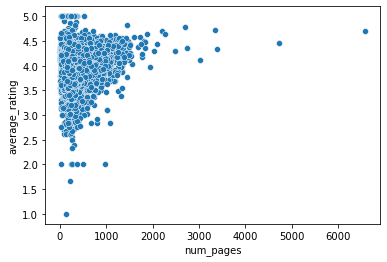

In [6]:
sns.scatterplot(x='num_pages', y='average_rating', data=db)

На основе предыдущих исследований количество страниц самый перспективный признак, на графике видно, что явно имеются выбросы. Среднее составляет 3.94 со стандартным отклонением 0.3. Мы будем решать задачу бинарной классификации, когда 0 - это плохие оценки (1,2,3), а 1 - хорошие, то есть 4 и 5.

In [7]:
bins = [0, 4, 5]            # группы, на которые мы разобьем среднюю оценку
groups_names = ['0', '1']   # название этих групп
db['rating_groups'] = pd.cut(db['average_rating'], bins, labels=groups_names, right=True).astype('int64') # проводим разбиение на группы
db = db.drop(['average_rating'], axis=1) # удаляем количественный признак, на основании которого построили бинарный

In [8]:
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10838 entries, 0 to 10837
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   num_pages           10838 non-null  int64 
 1   ratings_count       10838 non-null  int64 
 2   text_reviews_count  10838 non-null  int64 
 3   decade              10838 non-null  object
 4   quarter             10838 non-null  object
 5   tra_co              10838 non-null  object
 6   rating_groups       10838 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 592.8+ KB


In [9]:
db.head()

,num_pages,ratings_count,text_reviews_count,decade,quarter,tra_co,rating_groups
0,652,2095690,27591,2000,3,1,1
1,870,2153167,29221,2000,3,1,1
2,352,6333,244,2000,4,0,1
3,435,2339585,36325,2000,2,1,1
4,2690,41428,164,2000,3,1,1


Проверим, сколько наблюдений содержит каждый класс.

In [10]:
db['rating_groups'].value_counts(normalize=True)

0    0.574276
1    0.425724
Name: rating_groups, dtype: float64

Видим, что классы значительно различаются по количеству наблюдений. Следовательно, нужно будет решать задачу по дисбалансу классов.  

Мы будем использовать три подхода: 1) визуальный, 2) статистический, 3) машинное обучение. Визуализировать данные необходимо, так как именно визуально легче схватить какие-то значимые характеристики распределения данных (если данные это позволяют). Статистический подход необходим, чтобы понимать, как работает логистическая регрессия "под капотом". Машинное обучение позволяет проводить множество различных манипуляций с данными для улучшения модели предсказания.

Важно понимать разницу межу чисто статистическим подходом и машинным обучением. Для статистического подхода не требуется разделять данные на тренировочный и тестовый наборы.  

Мы применим большинство подходов, о которых упоминается в учебниках.

# Ищем простое решение
Всегда нужно исходить из бритвы Оккама: не надо плодить дополнительные сущности. Поэтому проведем проверку наших данных, как они есть.  

Книги о логистической регрессии:  
1) Изучаем Pandas М.Хейдт, А.Груздев (обязательно второе издание)  
2) Статья Binary Logistic Regression (datasklr.com)  

Суть метода логистической регрессии заключается в следующем:  
1) имеются признаки (количество страниц и др.) и целевой признак (0 - плохая оценка, 1 - хорошая оценка). Цель по имеющимся признакам предсказать целевой признак.  
2) вместо предсказания непосредственно целевого признака, мы предскажем вероятность класса 1 для конкретного наблюдения. Для этого будем работать не с самим классом, а с его вероятностью. Нужно использовать не саму вероятность, а натуральный логарифм шанса.  
3) в этом случае формула расчета приобретает вид, аналогичный линейной регрессии: слева логарифм шанса, а справа - признаки с коэффициентами.  
4) мы предсказываем логарифм по признакам с коэффициентами. Мы можем подогнать коэффициенты так, чтобы получить любой логарифм. Но так не пойдет, нам нужен механизм оценки вероятности. Поэтому используется метод максимального правдоподобия: считаем по всему набору данных, какой должна быть вероятность получить класс 1, чтобы у нас получилось ровно n наблюдений класса 1. Далее, мы подгоняем за счет коэффициентов наше уравнение с логарифмом таким образом, чтобы приблизиться максимально близко к оценке вероятности по всем наблюдениям. Другими словами, например, у нас 10 строк с наблюдениями. Мы подбираем такой коэффициент для каждого признака, чтобы умножение на него каждого наблюдения в признаке (и сложение по каждому признаку, умноженному по каждому наблюдению) на выходе давало максимальное приближение к вероятности, полученной ранее.

In [11]:
import statsmodels.formula.api as smf # модуль, который позволяет задать формулу в стиле R
model0 = smf.logit('rating_groups ~ num_pages + ratings_count + text_reviews_count + C(decade) + C(quarter) + C(tra_co)', data = db).fit() # вызываем и обучаем модель

         Current function value: 0.665534
         Iterations: 35
/Users/Shared/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [12]:
print(model0.summary()) # вызов результатов модели

                           Logit Regression Results                           
Dep. Variable:          rating_groups   No. Observations:                10838
Model:                          Logit   Df Residuals:                    10818
Method:                           MLE   Df Model:                           19
Date:                Sun, 06 Jun 2021   Pseudo R-squ.:                 0.02425
Time:                        17:56:34   Log-Likelihood:                -7213.1
converged:                      False   LL-Null:                       -7392.3
Covariance Type:            nonrobust   LLR p-value:                 1.789e-64
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            -22.8836   7.01e+04     -0.000      1.000   -1.38e+05    1.37e+05
C(decade)[T.1910]     21.2115   7.01e+04      0.000      1.000   -1.37e+05    1.37e+05
C(decade)[T.1920]   

Разберем этот вывод.  
- coef - это коэффициенты при независимых переменных в формуле логистической регрессии, где зависимой переменной выступает логит. Регрессионный коэффициент - это изменение логарифма отношения шансов данной зависимой переменной на единицу изменения независимой переменной при постоянных значениях всех остальных независимых переменных.
- P > |z| - это p-value. Нулевая гипотеза состоит в том, что коэффициент равен нулю.
- Log-Likelihood - это натуральный логарифм функции оценки максимального правдоподобия.
- LL-Null - это значение логарифмической вероятности модели, когда независимая переменная не включена (включен только перехват).
- LLR p-value - это проверка на принятие нулевой гипотезы: модель, в которой все коэффициенты равны 0 и которая определяется точкой пересечения с осью y, лучше, чем модель, в которой есть коэффициенты. Мы можем отклонить нулевую гипотезу.
- Pseudo R-squ - это отношение логарифмической вероятности нулевой модели к полной модели. То же, что коэффициент детерминации в линейной регрессии. Показывает уровень объясненной дисперсии. Чем ближе к 1, тем лучше. У нас это всего 0.024, то есть модель может объяснить только 2.4% дисперсии.
- Z-оценка - это коэффициент, деленный на стандартную ошибку. Чем ниже, тем лучше.  

Коэффициент для num_pages составляет 0.0014. Это значит, что для каждого увеличения количества страниц увеличиваются логарифмические шансы (не вероятность, а именно логарифм шанса), что книга имеет положительную оценку.

# Визуальный подход

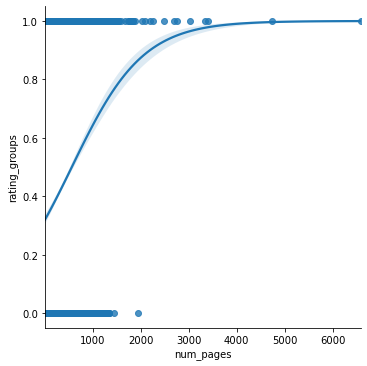

In [13]:
sns.lmplot(x = 'num_pages', y = 'rating_groups', data = db, logistic=True)

Линия регрессии показывает вероятность получить оценку 1 или 0. Например, при количестве страниц 1000 вероятность получить оценку 1 близка к 0.6.

# Статистический подход
## Подготовка признаков

Будем работать с отдельной копей наших данных, машинное обучение будем проводить на другой копии.  

1. Укрупним категории. Если категорий в признаке слишком много и они содержат мало наблюдений, то такие категории плохо будут разделять целевой признак на 0 и 1.  
2. Получим новые признаки.  
3. Масштабируем наши данные.

In [14]:
db_stat = db.copy()

In [15]:
# начнем с категориальных данных
# количество по категориям в процентах
db_stat['decade'].value_counts(normalize=True)

2000    0.676509
1990    0.224765
1980    0.056283
1970    0.018454
2010    0.012641
1960    0.006643
1950    0.002676
1920    0.000738
1940    0.000646
1910    0.000277
1930    0.000185
2020    0.000092
1900    0.000092
Name: decade, dtype: float64

In [16]:
# количество по категориям 
db_stat['decade'].value_counts()

2000    7332
1990    2436
1980     610
1970     200
2010     137
1960      72
1950      29
1920       8
1940       7
1910       3
1930       2
2020       1
1900       1
Name: decade, dtype: int64

Имеются категории, в которых всего несколько наблюдений. Очевидно, что такие категории не помогут в разделении цеелвого признака на 0 и 1, поэтому укрупним категории.

In [17]:
db_stat['decade'] = db_stat['decade'].replace(['1900','1910','1920','1930','1940','1950','2020'],'1960')

In [18]:
db_stat['decade'].value_counts()

2000    7332
1990    2436
1980     610
1970     200
2010     137
1960     123
Name: decade, dtype: int64

In [19]:
db_stat['quarter'].value_counts(normalize=True)

3    0.263056
4    0.250415
2    0.249769
1    0.236760
Name: quarter, dtype: float64

In [20]:
db_stat['tra_co'].value_counts(normalize=True)

0    0.599004
1    0.400996
Name: tra_co, dtype: float64

Распределение по кварталам и соавторству примерно одинаковое.  
Рассмотрим количественные признаки. Поделим количество оценок на количество отзывов (сколько приходится на один отзыв оценок).

In [21]:
db_stat['rating_reviews']= db_stat['ratings_count'] / db_stat['text_reviews_count']
# в результате деления может возникнуть NaN, заменим его на 1
db_stat['rating_reviews'].replace(np.nan,1,inplace=True)
# избавимся от бесконечности
db_stat['rating_reviews'].replace([np.inf, -np.inf],1,inplace=True)

Создадим новый признак: среднее значение количества страниц, если у книги есть соавто/переводчик.   
Для этого будем использовать функцию.
На вход функция принимает:  
- data - данные;
- cat-feat - категориальный признак;
- real-feat - количественный признак.  

Функция возвращает новый столбец данных, в котором для каждой группы в категориальных данных определяется среднее количественного признака.

In [22]:
def code_mean(data, cat_feat, real_feat):
    return (data[cat_feat].map(data.groupby(cat_feat)[real_feat].mean()))

In [23]:
db_stat['pages_decade'] = code_mean(db_stat, 'decade', 'num_pages')

In [24]:
db_stat

,num_pages,ratings_count,text_reviews_count,decade,quarter,tra_co,rating_groups,rating_reviews,pages_decade
0,652,2095690,27591,2000,3,1,1,75.955565,341.866067
1,870,2153167,29221,2000,3,1,1,73.685603,341.866067
2,352,6333,244,2000,4,0,1,25.954918,341.866067
3,435,2339585,36325,2000,2,1,1,64.407020,341.866067
4,2690,41428,164,2000,3,1,1,252.609756,341.866067
...,...,...,...,...,...,...,...,...,...
10833,512,156,20,2000,4,1,1,7.800000,341.866067
10834,635,783,56,1980,4,0,1,13.982143,371.821311
10835,415,820,95,1990,3,0,0,8.631579,351.500411
10836,434,769,139,2000,1,0,0,5.532374,341.866067


Масштабируем количественные признаки. Для этого можно использовать робастный планировщик, так как у нас есть выбросы. Но можно попробовать и другие.  
Определим признак, который будем шкалировать, передаим его шкалировщику, заменим исходный признак на масштабированный.  
Масштабирование желательно, но не обязательно. Масштабирование применяется, если признаки представлены разными шкалами (граммы и сантиметры) или значения одного признака слишком "отрываются" от другого. Это не наш случай, но мы все-таки применим этот метод.

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

In [26]:
# на основе тестов лучше всего справилось квантильное шкалирование, применим его
# список количественных признаков
col_names = ['num_pages', 'ratings_count', 'text_reviews_count', 'rating_reviews', 'pages_decade']
# создаем датафрейм с количественными признаками
features = db_stat[col_names]
# вызываем и обучаем шкалировщик
scaler = QuantileTransformer(n_quantiles=10, random_state=0).fit(features.values)
# преобразуем наши данные
features = scaler.transform(features.values)
# применяем результаты
db_stat[col_names] = features

# Обучение

In [27]:
# вызываем и обучаем модель
model = smf.logit('rating_groups ~ num_pages + ratings_count + text_reviews_count + C(decade) + C(quarter) + C(tra_co) + rating_reviews + pages_decade', data=db_stat).fit()

         Current function value: 0.662033
         Iterations: 35
/Users/Shared/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [28]:
print(model.summary())

                           Logit Regression Results                           
Dep. Variable:          rating_groups   No. Observations:                10838
Model:                          Logit   Df Residuals:                    10824
Method:                           MLE   Df Model:                           13
Date:                Sun, 06 Jun 2021   Pseudo R-squ.:                 0.02938
Time:                        17:56:56   Log-Likelihood:                -7175.1
converged:                      False   LL-Null:                       -7392.3
Covariance Type:            nonrobust   LLR p-value:                 1.211e-84
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.7659        nan        nan        nan         nan         nan
C(decade)[T.1970]     -0.0740        nan        nan        nan         nan         nan
C(decade)[T.1980]   

Value стало ниже (0.6620), но зато увеличилась объясненная дисперсия (0.029) и Log-Likelihood (7175), а также коэффициент при num_pages стал 0.5943. Можно попробовать другие шкалировщики.  
Модель хорошо реагирует на применение робастных шкалировщиков. Проблемы выбросов - одна из главных в наших данных и без ее решения получить примелемые результаты сложно. Здесь нас интересует механика, а не конкретный результат.

<AxesSubplot:>

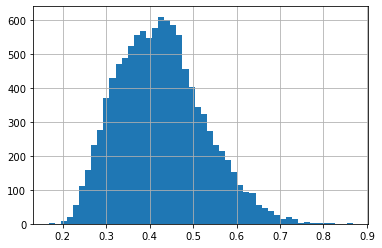

In [29]:
# получаем значение вероятности
proba = 1 / (1 + np.exp(-model.fittedvalues))
proba.hist(bins=50)

Эффективная модель делила бы вероятности на два класса, ближе к 0 или к 1.  
Неэффективная сосредотачивает вероятности возле 0.5.

In [30]:
# оставим только один признак
model1 = smf.logit('rating_groups ~ num_pages', data=db_stat).fit()

Optimization terminated successfully.
         Current function value: 0.678727
         Iterations 4


In [31]:
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          rating_groups   No. Observations:                10838
Model:                          Logit   Df Residuals:                    10836
Method:                           MLE   Df Model:                            1
Date:                Sun, 06 Jun 2021   Pseudo R-squ.:                0.004904
Time:                        17:59:14   Log-Likelihood:                -7356.0
converged:                       True   LL-Null:                       -7392.3
Covariance Type:            nonrobust   LLR p-value:                 1.661e-17
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.5982      0.040    -14.783      0.000      -0.678      -0.519
num_pages      0.6002      0.071      8.488      0.000       0.462       0.739
==============================================================================
"""

In [32]:
model1.params

Intercept   -0.598225
num_pages    0.600158
dtype: float64

Мы получаем регрессионный коэффициент в форме натурального логарифма. Поэтому увеличение или уменьшение такого коэффициента - это увеличение или уменьшение логарифма шанса. Но мы должны перевести его в запись через экспоненту, чтобы получить значение просто шанса. Кроме того, мы можем также получить значение вероятности.

In [33]:
# логарифм шанса в шанс
model_odds = pd.DataFrame(np.exp(model1.params), columns=['OR'])
model_odds ['z-value'] = model1.pvalues
model_odds[['2.5%', '97.5%']] = np.exp(model1.conf_int())
model_odds

,OR,z-value,2.5%,97.5%
Intercept,0.549786,1.882475e-49,0.507865,0.595168
num_pages,1.822406,2.109040e-17,1.586562,2.093309


# Машинное обучение. Базовый подход

Применение машинного обучения предполагает ответы на следующие вопросы:  
1) какую модель выбрать? у нас это логистическая регрессия.  
2) как подготовить данные? наша цель - получить такие признаки, которые будут хорошо разделять целевой признак на 1 и 0. Для этого мы должны преобразовать имеющиеся признаки и получить новые. В рамках этого мы постараемся привести количественные признаки к нормальному распределению и масштабируем данные. Категориальные данные мы закодируем. Как количественные, так и категориальные данные мы разобьем по группам.  
3) какие параметры модели мы будем настраивать и как? будем использовтаь решетчатый поиск с кросс-валидацией.  
4) что будет нашей оценкой качества модели? точность, а также матрица ошибок.  
5) как мы можем получить предсказания по новым данным?  

Порядок действий такой:  
1) разделяем данные на тренировочный и тестовый наборы;  
2) обрабатываем признаки;  
3) задаем модель логистической регрессии;  
4) тренируем модель с настройкой параметров и оценкой;  
5) выбираем лучшую модель;  
6) применяем для новых данных.

Важно помнить следующие два обстоятельства:  
1) всегда нужно стремиться найти самую простую и эффективную модель. Поэтому начинать стоит с базовой.  
2) когда мы готовим наши данные для машинного обучения, мы можем добавлять признаки, очищать их, модифицировать до разделения на тренировочный и тестовый наборы или после. До разделения мы можем применять только нематематические методы, которым не требуются расчеты на всем датафрейме. Все математические методы, которые требуют расчетов, нужно применять только после разделения на тренировочный и тестовый наборы, причем только на тренировочном (с последующим применением результатов к тестовому). 

Условия применения логистической регрессии:  
1) нормальное распределение (желательно, но не обязательно);  
2) единый масштаб измерений;  
3) отсутствие взаимосвязи между предикторами.

### Разделяем данные на тренировочный и тестовый наборы

In [34]:
db_ml = db.copy()
X = db_ml.drop(['rating_groups'], axis=1) # признаки
y = db_ml['rating_groups'] # целевой признак

In [35]:
# разделяем данные на тренировочный и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)
# stratify используется для получения в наших выборках пропорции целевого признака как в генеральной совокупности

### Подготовка данных
1) применим кодировщик для категориальных данных;  
2) приведем количественные признаки к нормальному распределению;  
3) произведем биннинг;  
4) выполним масштабирование количественных данных;  
5) отбор признаков.  

Начнем с кодировки категориальных данных, для этого используем метод кодирования средним значением зависимой переменной с использованием сглаживания через сигмоидальную функцию по схеме leave-one-out (просто оцениваются вероятности класса для конкретного признанка и всего набора, а также применяется сигмоидальная функция). Вероятность определяется с вычетом того наблюдения, которое мы непосредственно кодируем.

### Кодирование категориальных данных

In [36]:
! pip install category_encoders
from category_encoders import TargetEncoder

     |████████████████████████████████| 80 kB 791 kB/s 


In [39]:
# вызываем кодировщик и тренируем его на обучающем наборе
encoder = TargetEncoder(cols=['decade', 'quarter', 'tra_co']).fit(X_train, y_train)

# применяем к данным тренировочного набора
train_enc = encoder.transform(X_train)

# для тестового набора применяем только transform, не тренируем
test_enc = encoder.transform(X_test)

/Users/Shared/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [43]:
train_enc.head()

,num_pages,ratings_count,text_reviews_count,decade,quarter,tra_co
6963,480,4603,121,0.410788,0.446997,0.469757
8594,272,3124,74,0.410788,0.427464,0.469757
4784,352,13846,193,0.410788,0.404737,0.396347
7586,484,2524,40,0.447581,0.427464,0.396347
3352,617,562,42,0.447581,0.446997,0.396347


### Приведение количественных признаков к нормальному распределению
Нормальное распределение желательно, но не обязательно. Нормальное распределение нам необходимо, если мы ориентируемся в исследовании на какие-то параметры такого распределения (как, например, при проведении параметрических статистических тестах).

/Users/Shared/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


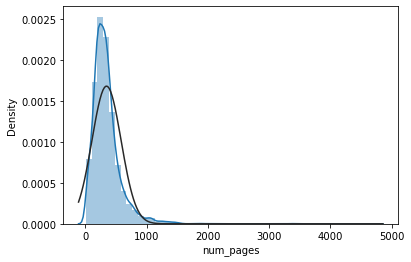

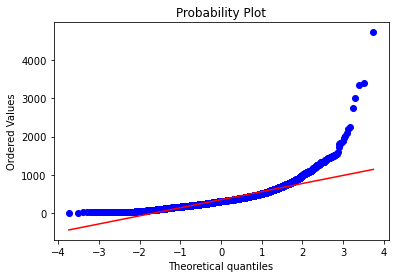

In [45]:
from scipy.stats import norm
from scipy import stats
sns.distplot(train_enc['num_pages'], fit=norm)
fig = plt.figure()
res = stats.probplot(train_enc['num_pages'], plot=plt)

In [46]:
db_ml['num_pages'].skew() # скошенность

4.4888374522680765

In [47]:
train_enc['num_pages'],fitted_lambda = stats.boxcox(train_enc['num_pages']) # преобразование Бокса-Кокса

In [48]:
a = 0.0001
train_enc['ratings_count'] = np.log(train_enc['ratings_count'] + a) # логарифмическое преобразование
train_enc['text_reviews_count'] = np.log(train_enc['text_reviews_count'] + a) # логарифмическое преобразование

In [49]:
# для тестовой выборки
test_enc['num_pages'] = stats.boxcox(test_enc['num_pages'], fitted_lambda) # преобразование Бокса-Кокса
test_enc['ratings_count'] = np.log(test_enc['ratings_count'] + a) # преобразование Бокса-Кокса
test_enc['text_reviews_count'] = np.log(test_enc['text_reviews_count'] + a) # преобразование Бокса-Кокса

### Биннинг